## Import Area

In [ ]:
#Common
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import numpy as np
#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.models import resnet18
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torchvision import transforms
import torch.optim as optim
from torchsummary import summary
#from google.colab import drive
#drive.mount('/content/gdrive')

## Data

### Download from gdrive

Source: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

In [ ]:
!apt install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-7build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1ackNIbORQyJxpxbWA1-GhMGxaqsVxvjt/view?usp=drive_link -O dataset.zip
!7z x dataset.zip
!rm dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1ackNIbORQyJxpxbWA1-GhMGxaqsVxvjt
To: /content/dataset.zip
100% 158M/158M [00:04<00:00, 32.6MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 158152771 bytes (151 MiB)

Extracting archive: dataset.zip
 49% 4096 Open              --
Path = dataset.zip
Type = zip
Physical Size = 158152771

  0%      2% 151 - dataset/test/king of spades/4.jpg                                              4% 320 - dataset/test/two of spades/5.jpg                                             5% 402 - dataset/train/ace of club

### Preprocess

### Load

In [ ]:
DS_ROOT = './dataset'

In [ ]:
df = pd.read_csv(os.path.join(DS_ROOT, 'cards.csv'))

In [ ]:
df.head(5)

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


### Make lookup table

In [ ]:
class_labels = df['labels'].unique().tolist()
card_type = df['card type'].unique().tolist()

In [ ]:
print(card_type)

['ace', 'eight', 'five', 'four', 'jack', 'xxx', 'king', 'nine', 'queen', 'seven', 'six', 'ten', 'three', 'two']


In [ ]:
# Drop
try:
  df = df.drop('labels', axis=1)
  df = df.drop('card type', axis=1)
except:
  None
df

,class index,filepaths,data set
0,0,train/ace of clubs/001.jpg,train
1,0,train/ace of clubs/002.jpg,train
2,0,train/ace of clubs/003.jpg,train
3,0,train/ace of clubs/004.jpg,train
4,0,train/ace of clubs/005.jpg,train
...,...,...,...
8149,52,valid/two of spades/1.jpg,valid
8150,52,valid/two of spades/2.jpg,valid
8151,52,valid/two of spades/3.jpg,valid
8152,52,valid/two of spades/4.jpg,valid


### Make dataset

#### Definition

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, target_transform=None):
        self.img_labels = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        #Image: Path -> PIL.Image -> Tensor(Tranfrom)
        #Label: int -> Tensor(Transform)
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

#### Create dataset

In [ ]:
train_df = df.groupby("data set").get_group('train')
train_df = train_df.drop('data set',axis = 1)
test_df = df.groupby("data set").get_group('test')
test_df = test_df.drop('data set',axis = 1)
valid_df = df.groupby("data set").get_group('valid')
valid_df = valid_df.drop('data set',axis = 1)

#### Transform

In [ ]:
tform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

tform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#### Final

In [ ]:
train_ds = CustomImageDataset(train_df, DS_ROOT, tform_train)
test_ds = CustomImageDataset(test_df, DS_ROOT, tform_test)
valid_ds = CustomImageDataset(valid_df, DS_ROOT, tform_train)

### Have a glance

Showing the image after normalize

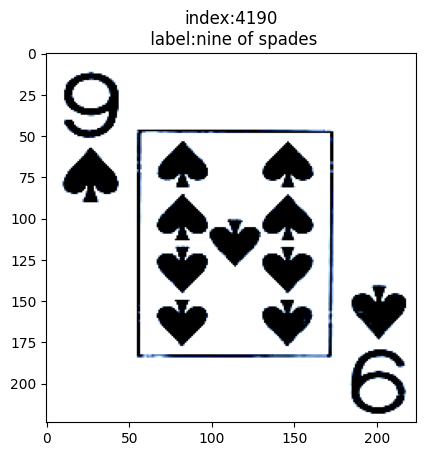

In [ ]:
idx = random.randint(0, len(train_ds)-1)
img, lbl = train_ds[idx]
img = img.permute(1, 2, 0).numpy()
lbl = class_labels[lbl]
plt.title(f"index:{idx}\n label:{lbl}")
plt.imshow(img)
plt.show()

## Model

In [ ]:
model = resnet18(weights='DEFAULT')
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(512, len(class_labels))
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


In [ ]:
summary(model, input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Train

### Configs

In [ ]:
class Config:
  epoch = 30
  batch_size = 32
  num_workers = 0
  lr = [1e-6, 1e-4, 1e-2]
  lr_step = 30
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  patience = 3
  checkpoints = "./4.pth"
  test_model = ""

### Fine tuning method

In [ ]:
#Param1 -> bottom few layers 10^-6
#Param2 -> others 10^-4
#Param3 -> addition layer 10^-2
modelParams = []
temps = []

for param in list(model.parameters())[0:3]:
  temps.append(param)

modelParams.append(temps)

temps = []
for param in list(model.parameters())[3:-2]:
  temps.append(param)

modelParams.append(temps)

temps = []
for param in list(model.parameters())[-2:]:
  temps.append(param)

modelParams.append(temps)

### Dataloader

In [ ]:
print(len(train_ds))
train_dataLoader = DataLoader(train_ds, batch_size=Config.batch_size, shuffle=True,
                num_workers=Config.num_workers, drop_last=True)

7624


In [ ]:
print(len(valid_ds))
valid_dataLoader = DataLoader(valid_ds, batch_size=Config.batch_size, shuffle=True,
                num_workers=Config.num_workers, drop_last=True)

265


### Checkpoint

In [ ]:
# Checkpoints Setup
# Using when training
# os.makedirs(Config.checkpoints, exist_ok=True)

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1a8-86QEWRNLITkSNQxZCAk-nCEfU7Olu/view?usp=drive_link -O 4.pth

Downloading...
From: https://drive.google.com/uc?id=1a8-86QEWRNLITkSNQxZCAk-nCEfU7Olu
To: /content/4.pth
100% 135M/135M [00:01<00:00, 72.9MB/s]


In [ ]:
need_to_train = False #Set true if you want to continue training
last_epoch = -1
try:
  # Using when training
  # weight_list = os.listdir(Config.checkpoints)
  # weight_list = [w.split('.')[0] for w in weight_list]
  # lastest_weight = f"{weight_list[-1]}.pth"
  # best_weight_dir = os.path.join(Config.checkpoints, lastest_weight)

  # Load checkpoint(weight, last_epoch, loss) in to model
  best_weight_dir = "./4.pth"
  checkpoint = torch.load(best_weight_dir, map_location=Config.device)
  model.load_state_dict(checkpoint['model_state_dict'])
  last_epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  Config.test_model = best_weight_dir
  print(f"Load best weight path:{best_weight_dir}, epoch:{last_epoch} / {Config.epoch}, loss:{loss}")
except Exception as e:
  print(e)
  need_to_train = True

Load best weight path:./4.pth, epoch:4 / 30, loss:0.007940109819173813


### Setup of tools

In [ ]:
# Training Setup

# Loss -> cross entropy
criterion = nn.CrossEntropyLoss()

# Optimer -> Adam
optimizer = optim.Adam(
    [
        {'params': modelParams[0], 'lr':Config.lr[0]},
        {'params': modelParams[1], 'lr':Config.lr[1]},
        {'params': modelParams[2], 'lr':Config.lr[2]},
    ],
    lr=Config.lr[1],
)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=Config.lr_step, gamma=0.1)

### Training

In [ ]:
training_loss = []
validation_loss = []
training_acc = []
validation_acc = []
train_last_epoch = 0

In [ ]:
if need_to_train:
  model.to(Config.device)
  best_loss = 100 #For valid set
  count = 0

  # Iteriate
  for e in range(last_epoch + 1, Config.epoch):
    # Train
    correct_count = 0
    train_last_epoch = e
    model.train()

    with tqdm(train_dataLoader, desc=f"Epoch {e}/{Config.epoch}", total=len(train_dataLoader)) as progress_bar:
      for data, labels in progress_bar:
        #To cpu/gpu
        data = data.to(Config.device)
        labels = labels.to(Config.device)
        #Gradient descent
        optimizer.zero_grad()
        #Output
        outputs = model(data)
        #Gradient descent by loss
        train_loss = criterion(outputs, labels)
        train_loss.backward()
        #Optimzer
        optimizer.step()

        #Get prediction and count accuracy
        _, preds = torch.max(outputs, 1)
        correct_count += torch.sum(preds == labels.data)

        progress_bar.set_postfix({"loss": train_loss.item()})

    acc = correct_count.double() / (len(train_dataLoader) * Config.batch_size)

    print(f"Epoch {e}/{Config.epoch}, Train loss: {train_loss}, acc: {acc}")
    #Record
    training_loss.append(train_loss)
    training_acc.append(acc)

    #Evalution mode
    correct_count = 0
    torch.cuda.empty_cache()
    model.eval()

    with tqdm(valid_dataLoader, desc=f"Epoch {e}/{Config.epoch}", total=len(valid_dataLoader)) as progress_bar:
      for data, labels in progress_bar:
        # To cpu/gpu
        data = data.to(Config.device)
        labels = labels.to(Config.device)
        # Get output
        outputs = model(data)
        # Loss cal
        val_loss = criterion(outputs, labels)

        # Predicitons
        _, preds = torch.max(outputs, 1)
        correct_count += torch.sum(preds == labels.data)

        progress_bar.set_postfix({"loss": val_loss.item()})

    acc = correct_count.double() / (len(valid_dataLoader) * Config.batch_size)
    print(f"Epoch {e}/{Config.epoch}, Validation loss: {val_loss}, acc: {acc}")
    # Record
    validation_loss.append(val_loss)
    validation_acc.append(acc)

    # If loss smaller than before
    if val_loss < best_loss:
      count = 0
      best_loss = val_loss
      # At this point also save a snapshot of the current model
      backbone_path = os.path.join(Config.checkpoints, f"{e}.pth")
      torch.save({
      'epoch': e,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': val_loss,
      }, backbone_path)
      Config.test_model = backbone_path
    else:
      # Early stop
      count += 1
      if count >= Config.patience:
        break

    #Clean cache
    del train_loss, val_loss, outputs
    torch.cuda.empty_cache()

    scheduler.step()

#### Graph showing

In [ ]:
training_loss = list(map(float, training_loss))
validation_loss = list(map(float, validation_loss))

if train_last_epoch != 0:
  epochs = range(0, train_last_epoch + 1)

  plt.plot(epochs, training_loss, label='Training Loss')
  plt.plot(epochs, validation_loss, label='Validation Loss')

  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.legend(loc='best')
  plt.show()

In [ ]:
training_acc = list(map(float, training_acc))
validation_acc = list(map(float, validation_acc))

In [ ]:
if train_last_epoch != 0:
  epochs = range(0, train_last_epoch + 1)

  plt.plot(epochs, training_acc, label='Training Accuracy')
  plt.plot(epochs, validation_acc, label='Validation Accuracy')

  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.legend(loc='best')
  plt.show()

## Test

### Load weight

In [ ]:
#Load weight, loss, epoch
checkpoint = torch.load(Config.test_model, map_location=Config.device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(f"Load best weight path:{Config.test_model}, epoch:{last_epoch} / {Config.epoch}, loss:{loss}")

Load best weight path:./4.pth, epoch:4 / 30, loss:0.007940109819173813


### Data loader

In [ ]:
test_dataLoader = DataLoader(test_ds, shuffle=True)

### Test

### Card


In [ ]:
correct_count = 0
model.eval()
model.to(Config.device)

with tqdm(test_dataLoader, total=len(test_dataLoader)) as progress_bar:
  for data, lbl in progress_bar:
    #To cpu/gpu
    data = data.to(Config.device)
    lbl = lbl.to(Config.device)
    #Get output
    outputs = model(data)
    #Cal loss
    loss = criterion(outputs, lbl)
    #Get prediction
    _, preds = torch.max(outputs, 1)
    correct_count += torch.sum(preds == lbl.data)

print(f"Loss: {loss}, acc: {correct_count.double() / (len(test_dataLoader))}")

100%|██████████| 265/265 [00:25<00:00, 10.25it/s]

Loss: 0.0010851691477000713, acc: 0.9320754716981132


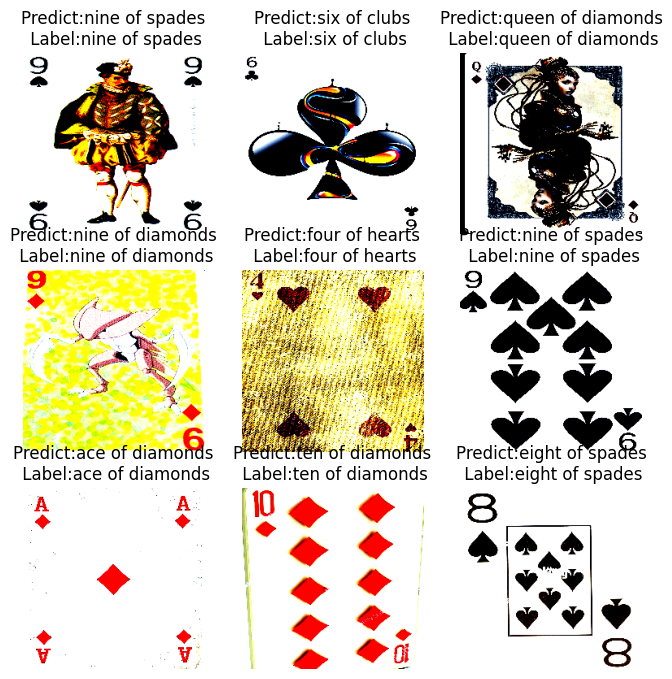

In [ ]:
w = 10
h = 10

columns = 3
rows = 3

fig = plt.figure(figsize=(8, 8))
ax = []

for i in range(1, columns*rows +1):
  #Random fetch image in test dataset
  idx = random.randint(0, len(test_ds)-1)
  show_img, show_lbl = test_ds[idx]
  show_img, show_lbl = show_img.to(Config.device), show_lbl

  #Fit input shape
  x = show_img
  x = x.unsqueeze(0)

  #Evaluation
  model.eval()
  model = model.to(Config.device)

  #Get output without gradent descend
  with torch.no_grad():
      out = model(x)

  show_img, show_lbl, out = show_img.cpu(), show_lbl, out.cpu()

  #Show in subplot
  ax.append(fig.add_subplot(rows, columns, i))
  ax[-1].set_title(f"Predict:{class_labels[np.argmax(out)]}\n Label:{class_labels[show_lbl]}")
  plt.imshow(show_img.permute(1, 2, 0))

  plt.axis('off')

plt.show()

## Try on your own image

In [ ]:
from PIL import Image
import requests

url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR6wb72KsLrKIIFaRT9TJypSEaT3sTxc7flv8SrkCsj_iltbSwR8_AmcALJg2LjwkMfJK4&usqp=CAU'
im = Image.open(requests.get(url, stream=True).raw)

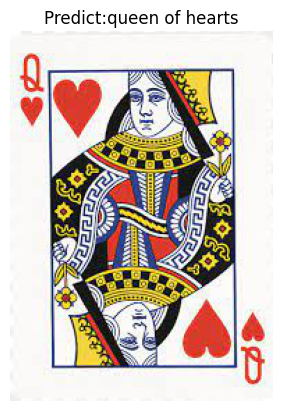

In [ ]:
#Tranform to fit input shape
x = tform_test(im)
x = x.unsqueeze(0)
x = x.to(Config.device)

#Evaluation
model.eval()
model = model.to(Config.device)

#No gradient
with torch.no_grad():
    out = model(x)

#Get output
show_img, out = im, out.cpu()

#Print model prediction
plt.title(f"Predict:{class_labels[np.argmax(out)]}")
plt.imshow(show_img)
plt.axis('off')

plt.show()